# Analysis functions

In [41]:
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq
from scipy.integrate import odeint
from matplotlib.patches import Patch
from scipy.stats import linregress

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
  
def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std 
  
def completion_at_time(data,
                      baseline_data,
                      triggered_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      baseline_conditions,
                      triggered_conditions,
                      experimental_level,
                      base_line_level,
                      triggered_level,
                      verbose = False):


  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(baseline_data, baseline_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(triggered_data, triggered_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)

def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

def timeToSec(time_string):
  split_string = time_string.split(":")
  return int(split_string[0])*3600 + int(split_string[1])*60 + int(split_string[2])

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out
  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)
    
  
def getTriplicatesJackknife(startTime, offset, level, x, data, conditions, fit):
    """
    Leave-one-out version of getAverageCurve.
    Returns 3 average curves and their standard deviations, each leaving out one replicate.

    Args:
    - startTime (float): Start time for truncating the curves.
    - offset (float): Time offset to apply to x values.
    - level: Condition label to match columns.
    - x (list or array): Full time array.
    - data (DataFrame): Curve data in columns.
    - conditions (dict): Mapping of column names to experimental conditions.
    - fit (tuple): Background subtraction and normalization (offset, scale).

    Returns:
    - x_vals (list): Timepoints corresponding to returned curves.
    - y_curves (list of 3 lists): Each is a leave-one-out average curve.
    - y_stds   (list of 3 lists): Each is the std deviation matching the y_curves.
    """
    y_all = []
    for i, c in enumerate(data.columns):
        if i >= 1 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_all.append(ynew)

    if len(y_all) != 3:
        print(conditions[level])
        for y in y_all:
          print(y[0:10])
        raise ValueError(f"Expected 3 replicates, found {len(y_all)} for level {level}")

    x_vals = [i + offset - startTime for i in x if i >= startTime]

    y_curves = []
    y_stds = []

    for i in range(3):
        subset = [y for j, y in enumerate(y_all) if j != i]
        avg, std = average_and_std(subset)
        y_curves.append(avg)
        y_stds.append(std)

    return x_vals, y_curves, y_stds


def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()

# Importing data

In [42]:
UW_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_controls = {'R alone' : ['B10', 'C10', 'D10'], #actually cascade alone
                          'R(nn) alone' : ['E10', 'F10', 'G10']}
offset_UW_controls = 0
t_UW_controls = [timeToSec(t) + offset_UW_controls for t in UW_controls['Time'].values]

UW_casc_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc_controls = {'Cascade' : ['B5', 'C5', 'D5'],
                                'Cascade(nn)' : ['E5', 'F5', 'G5']}
offset_UW_casc_controls = 0
t_UW_casc_controls = [timeToSec(t) + offset_UW_casc_controls for t in UW_casc_controls['Time'].values]


UW_trig = pd.read_csv('UW_Cascades.csv')
conditions_UW_trig = {'N50_25uM nat' : ['B9', 'C9', 'D9'],
                      'N50_25uM nn' : ['E9', 'F9', 'G9']}
offset_UW_trig = 190
t_UW_trig = [timeToSec(t) + offset_UW_trig for t in UW_trig['Time'].values]


UW_casc = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc = {'N50_25uM nat' : ['B8', 'C8', 'D8'],
                     'N50_25uM nn' : ['E8', 'F8', 'G8']}
offset_UW_casc = 190
t_UW_casc = [timeToSec(t) + offset_UW_casc for t in UW_casc['Time'].values]


UW_no = pd.read_csv('UW_Cascades.csv')

conditions_UW_no = {'N50_25uM nat' : ['B13', 'C13', 'D13'],
             'N50_25uM nn' : ['E13', 'F13', 'G13']}
offset_UW_no = 190
t_UW_no = [timeToSec(t) + offset_UW_no for t in UW_no['Time'].values]



TUM_controls = pd.read_csv('TUM_Controls.csv')
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_casc_controls = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_casc_controls = {'Cascade' : ['Cascade_1',	'Cascade_2',	'Cascade_3'],
                                'Cascade(nn)' : ['Cascade(nn)_1',	'Cascade(nn)_2',	'Cascade(nn)_3']}
offset_TUM_casc_controls = 0
t_TUM_casc_controls = [int(t) + offset_TUM_casc_controls for t in TUM_casc_controls['time'].values]


TUM_no = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]


TUM_trig = pd.read_csv('TUM_Cascades_TrigIncub.csv')
conditions_TUM_trig = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_casc = pd.read_csv('TUM_Cascades_CascIncub.csv')
conditions_TUM_casc = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                       'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                       'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                       'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                       'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                       'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                       'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                       'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                        'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                        'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                        }
offset_TUM_casc = 0
t_TUM_casc = [int(t) + offset_TUM_casc for t in TUM_casc['time'].values]


number_of_points = 6*3600//60

# Processing TUM data

## controls

In [43]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

Fitted kf = 5.4e+03 ± 4.0e+02 (jackknife SE, n=3)


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/3523817383.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


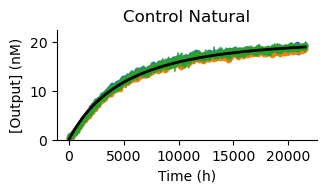

In [44]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[0]]
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nat = [[kf_mean, kf_se]]
fitted_kf = k_control_nat[0][0]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/559766482.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))
/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/559766482.py:53: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]


Fitted kf = 1.0e+04 ± 5.8e+02 (jackknife SE, n=3)


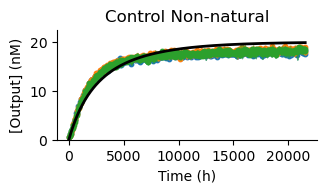

In [45]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[1]]
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e6


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nn = [[kf_mean, kf_se]]
fitted_kf = k_control_nn[0][0]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

#plt.savefig('control_nnn_k.svg', dpi = 400)

plt.show()



# 6 hour fits

## No incubation

In [46]:
t1 = t_TUM_controls
data1 = TUM_controls
conditions1 = conditions_TUM_controls
t2 = t_TUM_casc_controls
data2 = TUM_casc_controls
conditions2 = conditions_TUM_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i,l in enumerate(levels1):
    dfArray.append(getEndpoint(l, t1, data1, conditions1))
for i,l in enumerate(levels2):
    dfArray.append(getEndpoint(l, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
2,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
3,Cascade,16789.3,17054.0,16423.0,16755.433333,258.715369
4,Cascade(nn),16496.0,15884.3,16110.8,16163.700000,252.511425


In [47]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

### nat

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/483643669.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 1.5e+03 ± 4.3e+01 (jackknife SE)
Fitted kf = 6.2e+02 ± 1.6e+01 (jackknife SE)
Fitted kf = 2.0e+02 ± 9.0e+00 (jackknife SE)
Fitted kf = 5.9e+01 ± 4.9e+00 (jackknife SE)


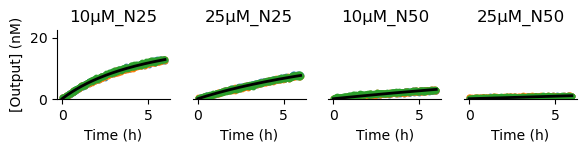

In [48]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1


def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_casc_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/2718413137.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 4.8e+03 ± 2.3e+02 (jackknife SE)
Fitted kf = 2.5e+03 ± 1.4e+02 (jackknife SE)
Fitted kf = 8.7e+02 ± 8.2e+01 (jackknife SE)
Fitted kf = 2.3e+02 ± 1.1e+01 (jackknife SE)


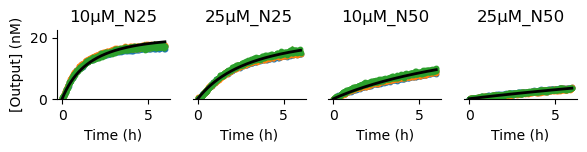

In [49]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_casc_nn_noinc.svg', dpi = 400, transparent=True)
plt.show()



## Trigger incubation

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/593507640.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 9.5e+02 ± 4.0e+01 (jackknife SE)
Fitted kf = 4.0e+02 ± 1.2e+01 (jackknife SE)
Fitted kf = 1.3e+02 ± 6.8e+00 (jackknife SE)
Fitted kf = 6.4e+01 ± 3.4e+00 (jackknife SE)


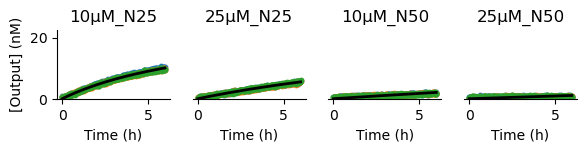

In [50]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_trig_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')
plt.savefig('TUM_casc_nat_trig.svg', dpi = 500, transparent=True)

plt.show()

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/1990238441.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 3.8e+03 ± 1.4e+02 (jackknife SE)
Fitted kf = 1.9e+03 ± 5.4e+01 (jackknife SE)
Fitted kf = 7.7e+02 ± 2.0e+01 (jackknife SE)
Fitted kf = 2.6e+02 ± 4.0e+00 (jackknife SE)


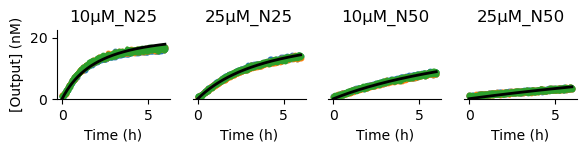

In [51]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}


curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_trig_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_casc_nn_trig.svg', dpi = 400, transparent=True)
plt.show()


## Reporter incubation

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/3819064578.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 1.4e+03 ± 8.3e+01 (jackknife SE)
Fitted kf = 6.0e+02 ± 6.5e+00 (jackknife SE)
Fitted kf = 1.6e+02 ± 9.9e+00 (jackknife SE)
Fitted kf = 3.3e+01 ± 2.9e+00 (jackknife SE)


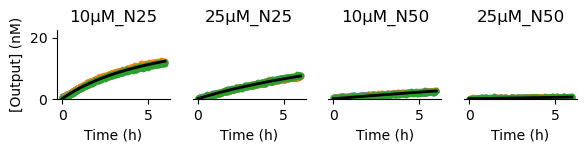

In [52]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]
data = TUM_casc[0:number_of_points]
conditions = conditions_TUM_casc
levels = list(conditions.keys())
offset = offset_TUM_casc
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e2


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_casc_nat_rep.svg', dpi = 400, transparent=True)
plt.show()


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/3938865589.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 3.0e+03 ± 1.4e+02 (jackknife SE)
Fitted kf = 1.9e+03 ± 9.6e+01 (jackknife SE)
Fitted kf = 8.3e+02 ± 2.6e+01 (jackknife SE)
Fitted kf = 2.2e+02 ± 1.4e+00 (jackknife SE)


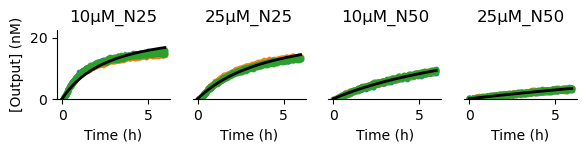

In [53]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_casc[0:number_of_points]
conditions = conditions_TUM_casc
levels = list(conditions.keys())
offset = offset_TUM_casc
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [4, 5, 6, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x

# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_casc_nn_rep.svg', dpi = 400, transparent=True)
plt.show()


## summary

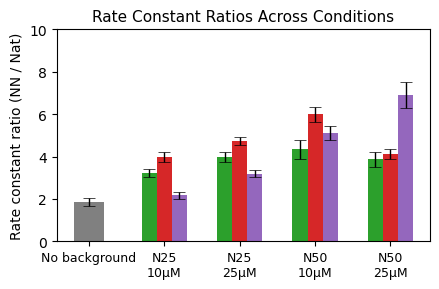

In [56]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation', 'Trigger incubated', 'Reporter incubated']
colors = [color_scheme[2], color_scheme[3], color_scheme[4]]
bar_width = 0.2

# Control baseline (gray)
controls = [k_control_nat, k_control_nn]
base = controls[1][0][0] / controls[0][0][0]
e_base = prop_err(controls[1][0], controls[0][0])

# Prepare experimental data
no = [k_no_nat, k_no_nn]
trig = [k_trig_nat, k_trig_nn]
rep = [k_rep_nat, k_rep_nn]
systems = [no, trig, rep]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_control = 0
x_group_start = 1  # reserve space for control
x_group = np.arange(n_groups) + x_group_start  # center position for each group
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)

# Control bar
ax.bar(x_control, base, bar_width*2, yerr=e_base, color='gray', label='No background', error_kw=error_params)

# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = [x_control] + list(x_group)
x_labels = ['No background'] + group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('Rate constant ratio (NN / Nat)', fontsize=10)
ax.set_ylim(0, 10)
ax.set_title('Rate Constant Ratios Across Conditions', fontsize=11)

plt.tight_layout()
#plt.savefig("Onestep_InitK_grouped_barplot_err.svg", dpi=400)
plt.show()


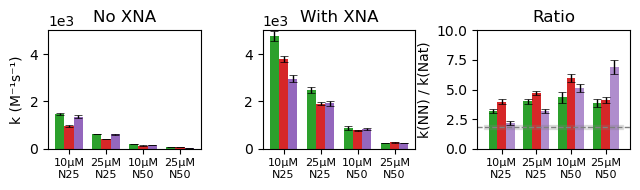


=== (1) Wald tests: Each bar vs control ratio ===
10μM N25     – No incubation    : ratio=3.210±0.179, Z= 5.419, p=5.981e-08, Holm=2.392e-07
10μM N25     – Trigger incubated: ratio=3.975±0.218, Z= 7.595, p=3.086e-14, Holm=2.160e-13
10μM N25     – Reporter incubated: ratio=2.175±0.167, Z= 1.321, p=1.866e-01, Holm=1.866e-01
25μM N25     – No incubation    : ratio=3.987±0.246, Z= 7.070, p=1.545e-12, Holm=9.267e-12
25μM N25     – Trigger incubated: ratio=4.717±0.192, Z=11.059, p=0.000e+00, Holm=0.000e+00
25μM N25     – Reporter incubated: ratio=3.193±0.164, Z= 5.597, p=2.177e-08, Holm=1.089e-07
10μM N50     – No incubation    : ratio=4.332±0.456, Z= 5.073, p=3.909e-07, Holm=1.173e-06
10μM N50     – Trigger incubated: ratio=5.993±0.352, Z=10.547, p=0.000e+00, Holm=0.000e+00
10μM N50     – Reporter incubated: ratio=5.108±0.350, Z= 8.316, p=0.000e+00, Holm=0.000e+00
25μM N50     – No incubation    : ratio=3.867±0.367, Z= 4.947, p=7.519e-07, Holm=1.504e-06
25μM N50     – Trigger incubated: ra

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.stats import norm

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)


def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0]) * res_num[1])**2 +
                   ((res_num[0] / (res_denom[0]**2)) * res_denom[1])**2)

labels = [u"10\u03bcM\nN25", u"25\u03bcM\nN25", u"10\u03bcM\nN50", u"25\u03bcM\nN50"]
x = np.arange(len(labels))  # [0, 1, 2, 3]
bar_width = 0.25

# ---------------------------------------------------------
# Data assembly
# ---------------------------------------------------------

# Group datasets by color group
# Format for panel0: (nat, nn, color, alpha)
datasets_panel0 = [
    (k_no_nat,   k_no_nn,   color_scheme[2], 1.0),
    (k_trig_nat, k_trig_nn, color_scheme[3], 1.0),
    (k_rep_nat,  k_rep_nn,  color_scheme[4], 1.0),
]

# Ratios k(NN)/k(Nat) + propagated errors for each background & incubation
k_no_diff = [[k_no_nn[i][0]   / k_no_nat[i][0],   prop_err(k_no_nn[i],   k_no_nat[i])]
             for i in range(len(k_no_nn))]
k_trig_diff = [[k_trig_nn[i][0] / k_trig_nat[i][0], prop_err(k_trig_nn[i], k_trig_nat[i])]
               for i in range(len(k_trig_nn))]
k_rep_diff = [[k_rep_nn[i][0]  / k_rep_nat[i][0],  prop_err(k_rep_nn[i],  k_rep_nat[i])]
              for i in range(len(k_rep_nn))]

datasets_panel1 = [
    (k_no_diff,   'No incubation',       color_scheme[2], 1.0),
    (k_trig_diff, 'Trigger incubated',   color_scheme[3], 1.0),
    (k_rep_diff,  'Reporter incubated',  color_scheme[4], 0.75),
]

error_params = dict(ecolor='black', lw=1, capsize=3, capthick=0.5)

# ---------------------------------------------------------
# Plot nat and nn (panels 0 and 1)
# ---------------------------------------------------------
for i, (nat_list, nn_list, color, scale) in enumerate(datasets_panel0):
    nat_y = [v[0] for v in nat_list]
    nat_err = [v[1] for v in nat_list]
    nn_y = [v[0] for v in nn_list]
    nn_err = [v[1] for v in nn_list]

    # x positions for this dataset
    dx = (i - 1) * bar_width  # shifts: -bar_width, 0, +bar_width
    ax[0].bar(x + dx, nat_y, width=bar_width, yerr=nat_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)
    ax[1].bar(x + dx, nn_y, width=bar_width, yerr=nn_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)

# ---------------------------------------------------------
# Panel 2: draw ratio bars
# ---------------------------------------------------------
for i, (diff_list, label, color, scale) in enumerate(datasets_panel1):
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    dx = (i - 1) * bar_width  # shift left, center, right
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err, error_kw=error_params,
              color=color, label=label, alpha=scale)

# Control ratio line + band
control_ratio = k_control_nn[0][0] / k_control_nat[0][0]
control_ratio_se = prop_err(k_control_nn[0], k_control_nat[0])

ax[2].axhline(y=control_ratio, color='gray', linestyle='--', linewidth=1)
ax[2].fill_between(
    [-0.5, 3.5],
    [control_ratio - control_ratio_se] * 2,
    [control_ratio + control_ratio_se] * 2,
    color='gray', alpha=0.2,
)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=8)
    a.tick_params(axis='x', labelrotation=0)

ax[0].set_ylim(0,5000)
ax[1].set_ylim(0,5000)
ax[2].set_ylim(0, 10)

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

# Set y-axis 0 and 1 to scientific notation
ax[0].yaxis.get_major_formatter().set_scientific(True)
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[1].yaxis.get_major_formatter().set_scientific(True)
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 1))

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

plt.tight_layout()
plt.savefig("NAR_casc_K.svg", dpi=400)
plt.show()

# ============================================================
# ===================== STATISTICS ===========================
# ============================================================

def wald_z(diff, se_diff):
    Z = diff / se_diff
    p = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p

def holm_correction(pvals):
    """Holm step-down adjustment; returns adjusted p-values in original order."""
    m = len(pvals)
    order = sorted(range(m), key=lambda i: pvals[i])  # indices sorted by p
    adjusted = [0.0] * m
    prev = 0.0
    for rank, i in enumerate(order):
        k = m - rank
        adj = min(1.0, pvals[i] * k)
        adj = max(adj, prev)  # enforce monotonicity
        adjusted[i] = adj
        prev = adj
    return adjusted

# Convenience: collect ratios by incubation type
# Each list is length 4 (one per background)
ratios_no   = k_no_diff
ratios_trig = k_trig_diff
ratios_rep  = k_rep_diff

backgrounds = [u"10\u03bcM N25", u"25\u03bcM N25", u"10\u03bcM N50", u"25\u03bcM N50"]
incubations = ["No incubation", "Trigger incubated", "Reporter incubated"]

# ============================================================
# (1) Which bars differ from the control ratio?
#     (12 tests; Holm across all 12)
# ============================================================

print("\n=== (1) Wald tests: Each bar vs control ratio ===")

all_bar_results = []
pvals_bar = []

for i, bg in enumerate(backgrounds):
    for inc_label, (ratio_list, tag) in zip(
        incubations,
        [(ratios_no, 'No'),
         (ratios_trig, 'Trigger'),
         (ratios_rep, 'Reporter')]
    ):
        est, se = ratio_list[i]
        diff = est - control_ratio
        se_diff = sqrt(se**2 + control_ratio_se**2)
        Z, p = wald_z(diff, se_diff)
        pvals_bar.append(p)
        all_bar_results.append({
            "background": bg,
            "incubation": inc_label,
            "ratio": est,
            "se": se,
            "diff": diff,
            "se_diff": se_diff,
            "Z": Z,
            "p_raw": p,
        })

p_adj_bar = holm_correction(pvals_bar)
for res, p_h in zip(all_bar_results, p_adj_bar):
    res["p_holm"] = p_h

for r in all_bar_results:
    print(f"{r['background']:12s} – {r['incubation']:17s}: "
          f"ratio={r['ratio']:.3f}±{r['se']:.3f}, "
          f"Z={r['Z']:6.3f}, p={r['p_raw']:8.3e}, Holm={r['p_holm']:8.3e}")


# ============================================================
# (2) Within each background: No vs Trigger / No vs Reporter
#     Holm per background
# ============================================================

print("\n=== (2) Wald tests: Within-background incubation comparisons ===")

for i, bg in enumerate(backgrounds):
    print(f"\nBackground {bg}:")
    # For this background i, get (ratio, se) for each incubation
    r_no,   se_no   = ratios_no[i]
    r_trig, se_trig = ratios_trig[i]
    r_rep,  se_rep  = ratios_rep[i]

    comps = [
        ("Trigger vs No",   r_trig, se_trig, r_no, se_no),
        ("Reporter vs No",  r_rep,  se_rep,  r_no, se_no),
    ]

    pvals = []
    rows = []
    for name, r2, se2, r1, se1 in comps:
        diff = r2 - r1
        se_diff = sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((name, diff, se_diff, Z, p))

    p_adj = holm_correction(pvals)
    for (name, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{name:14s}: diff={diff:6.3f}±{se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, Holm={p_corr:8.3e}")


# ============================================================
# (3) Global comparisons between incubation types
#     pooled across backgrounds (inverse-variance weighted)
#     Holm across the 3 global comparisons
# ============================================================

print("\n=== (3) Global (pooled) comparisons between incubation conditions ===")

inc_to_list = {
    "No incubation":      ratios_no,
    "Trigger incubated":  ratios_trig,
    "Reporter incubated": ratios_rep,
}

inc_pairs = [
    ("No incubation",      "Trigger incubated",  "No vs Trigger"),
    ("No incubation",      "Reporter incubated", "No vs Reporter"),
    ("Trigger incubated",  "Reporter incubated", "Trigger vs Reporter"),
]

global_results = []
pvals_global = []

for inc1, inc2, label in inc_pairs:
    list1 = inc_to_list[inc1]
    list2 = inc_to_list[inc2]

    num = 0.0
    den = 0.0

    for i in range(len(list1)):  # loop over 4 backgrounds
        r1, se1 = list1[i]
        r2, se2 = list2[i]
        diff_i = r2 - r1
        se_diff_i = sqrt(se1**2 + se2**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    global_results.append({
        "label": label,
        "pooled_diff": pooled_diff,
        "pooled_se": pooled_se,
        "Z": Z,
        "p_raw": p,
    })
    pvals_global.append(p)

p_adj_global = holm_correction(pvals_global)
for res, p_h in zip(global_results, p_adj_global):
    res["p_holm"] = p_h

for res in global_results:
    print(f"{res['label']:16s}: pooled diff={res['pooled_diff']:.3f}±{res['pooled_se']:.3f}, "
          f"Z={res['Z']:6.3f}, p={res['p_raw']:8.3e}, Holm={res['p_holm']:8.3e}")


# ============================================================
# (4) Pooled tests: does each x-axis background (4 levels)
#     as a whole differ from the control ratio?
#     Here we pool the three incubation bars (No/Trigger/Reporter)
#     for each background as independent estimates.
#     Holm-correction across the 4 backgrounds.
# ============================================================

print("\n=== (4) Pooled tests: each background vs control (pooled across incubations) ===")

pooled_bg_results = []
pvals_bg = []

for i, bg in enumerate(backgrounds):
    # For background i, collect (est, se) for No / Trigger / Reporter
    vals = [
        ratios_no[i],    # (est_no, se_no)
        ratios_trig[i],  # (est_trig, se_trig)
        ratios_rep[i],   # (est_rep, se_rep)
    ]

    num = 0.0
    den = 0.0

    for est, se in vals:
        diff_i = est - control_ratio
        se_diff_i = sqrt(se**2 + control_ratio_se**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    pooled_bg_results.append((bg, pooled_diff, pooled_se, Z, p))
    pvals_bg.append(p)

# Holm correction across the 4 backgrounds
p_adj_bg = holm_correction(pvals_bg)

for (bg, diff, se_pooled, Z, p_raw), p_corr in zip(pooled_bg_results, p_adj_bg):
    print(f"{bg:12s}: pooled diff={diff:6.3f}±{se_pooled:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:10.6e}, Holm={p_corr:10.6e}")



## Summary 

# Processing UW Data

In [58]:
#using baseline measured from untrigged reporter on 2025-06-18
fit_nat = [789.333333, (6299.700000 - 789.333333)/20]
fit_nn =  [278.600000	, (4571.900000	- 278.600000	)/20]

Fitted kf = 1.5e+05 ± 3.7e+04


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/3514084038.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


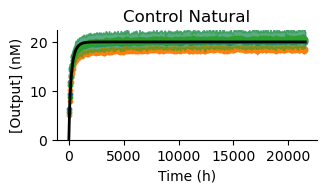

In [59]:

t = t_UW_casc_controls
data = UW_casc_controls[0:number_of_points]
conditions = conditions_UW_casc_controls

levels = list(conditions.keys())

fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


UW_k_control_nat = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



Fitted kf = 4.6e+05 ± 2.4e+05


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/2503516911.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


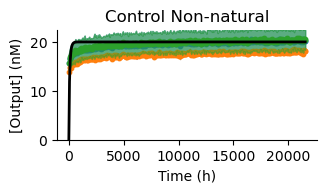

In [60]:

t = t_UW_casc_controls
data = UW_casc_controls[0:number_of_points]
conditions = conditions_UW_casc_controls

levels = list(conditions.keys())

fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


UW_k_control_nat = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



## No incubation


### NAt

Fitted kf = 1.1e+03 ± 1.1e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/960208775.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


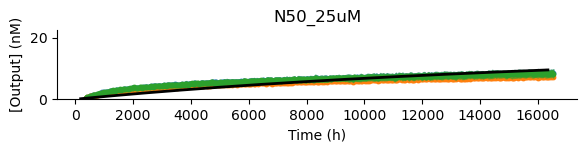

In [61]:
labels = ['N50_25uM']


data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 2e1


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nat = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_no_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



### NN

Fitted kf = 6.1e+03 ± 1.2e+03


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/669451615.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))
/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/669451615.py:55: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]


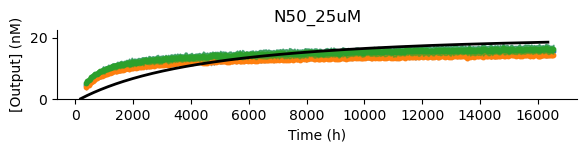

In [62]:
labels = ['N50_25uM']


data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 5e6


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nn = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_no_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



## Trig incubated

### NAt

Fitted kf = 9.0e+02 ± 9.9e+01


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/1007095159.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


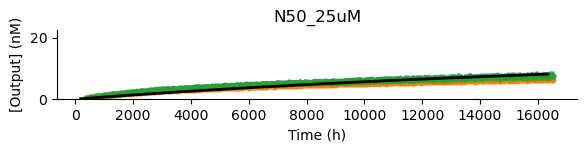

In [63]:
labels = ['N50_25uM']


data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 2e1


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nat = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_trig_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



### NN

Fitted kf = 4.1e+03 ± 4.5e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/3898553815.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


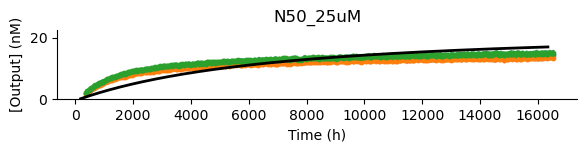

In [73]:
labels = ['N50_25uM']


data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 2e1


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nn = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_trig_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



## cascade inc

### NAt

Fitted kf = 1.4e+03 ± 1.5e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/803455047.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


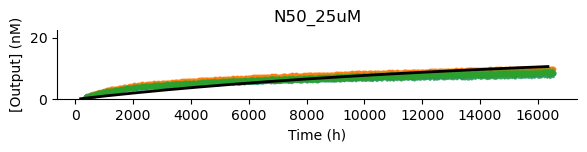

In [75]:
labels = ['N50_25uM']


data = UW_casc[0:number_of_points]
conditions = conditions_UW_casc
levels = list(conditions.keys())
offset = offset_UW_casc
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 2e1


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nat = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_rep_nat.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



### NN

Fitted kf = 2.0e+04 ± 7.1e+03


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_9499/2261936463.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


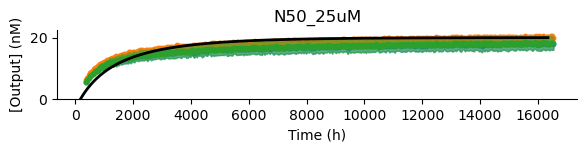

In [76]:
labels = ['N50_25uM']


data = UW_casc[0:number_of_points]
conditions = conditions_UW_casc
levels = list(conditions.keys())
offset = offset_UW_casc
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*1


initial_k = 2e1


x_list  = [x_trunc]*1




fig, ax = plt.subplots(1,1, figsize = (6.5,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nn = []
for i,a in enumerate([ax]):
  res = []
  for j,curve in enumerate(to_fit[i]):
    c = [1e9*e for e in curve]
    res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


    a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


  fitted_kf = np.mean(res)
  param_sd_kf = np.std(res)
  print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


  UW_k_rep_nn.append([fitted_kf,param_sd_kf])
  a.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

  a.set_xlabel('Time (h)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



ratio y, e: [3.8665071992099986, 5.358385655680055] [0.3671717855637175, 1.1505367687927635]
ratio y, e: [4.120263080923845, 4.570435466881795] [0.22978466920806281, 0.7048300810738535]
ratio y, e: [6.900756833643603, 14.651906589086726] [0.6204662252105281, 5.428470605724078]


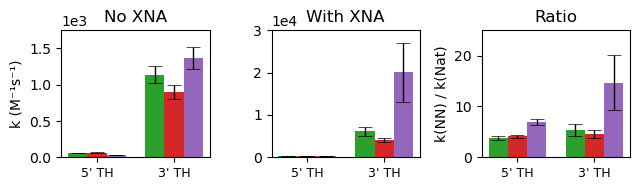


=== (Within-system) Wald tests: incubation comparisons within each system ===

System 5':
No vs Trigger: diff= 0.254 ± 0.433, Z= 0.586, p=5.580e-01, p_holm=5.580e-01
No vs Reporter: diff= 3.034 ± 0.721, Z= 4.209, p=2.570e-05, p_holm=5.140e-05

System 3':
No vs Trigger: diff=-0.788 ± 1.349, Z=-0.584, p=5.592e-01, p_holm=5.592e-01
No vs Reporter: diff= 9.294 ± 5.549, Z= 1.675, p=9.397e-02, p_holm=1.879e-01

=== (Between-system) Wald tests: 5' vs 3' for each incubation ===
No incubation    : diff=-1.492 ± 1.208, Z=-1.235, p=2.167e-01, p_holm=4.680e-01
Trigger incubated: diff=-0.450 ± 0.741, Z=-0.607, p=5.437e-01, p_holm=5.437e-01
Reporter incubated: diff=-7.751 ± 5.464, Z=-1.419, p=1.560e-01, p_holm=4.680e-01


In [89]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.stats import norm

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)

labels = ["5' TH", "3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 +
                   ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# ---------------------------------------------------------
# Data assembly for the three panels
# ---------------------------------------------------------

# Panel 0: No incubation
no_nat_data_together = [k_no_nat[3],      UW_k_no_nat[0]]
no_nn_data_together  = [k_no_nn[3],       UW_k_no_nn[0]]
no_R_data_together   = [
    [k_no_nn[3][0]      / k_no_nat[3][0],      prop_err(k_no_nn[3],      k_no_nat[3])],
    [UW_k_no_nn[0][0]   / UW_k_no_nat[0][0],   prop_err(UW_k_no_nn[0],   UW_k_no_nat[0])]
]

# Panel 1: Trigger incubated
trig_nat_data_together = [k_trig_nat[3],   UW_k_trig_nat[0]]
trig_nn_data_together  = [k_trig_nn[3],    UW_k_trig_nn[0]]
trig_R_data_together   = [
    [k_trig_nn[3][0]    / k_trig_nat[3][0],    prop_err(k_trig_nn[3],    k_trig_nat[3])],
    [UW_k_trig_nn[0][0] / UW_k_trig_nat[0][0], prop_err(UW_k_trig_nn[0], UW_k_trig_nat[0])]
]

# Panel 2: Reporter incubated
rep_nat_data_together = [k_rep_nat[3],     UW_k_rep_nat[0]]
rep_nn_data_together  = [k_rep_nn[3],      UW_k_rep_nn[0]]
rep_R_data_together   = [
    [k_rep_nn[3][0]     / k_rep_nat[3][0],     prop_err(k_rep_nn[3],     k_rep_nat[3])],
    [UW_k_rep_nn[0][0]  / UW_k_rep_nat[0][0],  prop_err(UW_k_rep_nn[0],  UW_k_rep_nat[0])]
]

# Grouped data for each condition and panel
datasets_panel0 = [
    (no_nat_data_together,   color_scheme[2], -bar_width),
    (trig_nat_data_together, color_scheme[3],  0),
    (rep_nat_data_together,  color_scheme[4],  bar_width),
]
datasets_panel1 = [
    (no_nn_data_together,    color_scheme[2], -bar_width),
    (trig_nn_data_together,  color_scheme[3],  0),
    (rep_nn_data_together,   color_scheme[4],  bar_width),
]
datasets_panel2 = [
    (no_R_data_together,     color_scheme[2], -bar_width),
    (trig_R_data_together,   color_scheme[3],  0),
    (rep_R_data_together,    color_scheme[4],  bar_width),
]

error_params = dict(ecolor='black', lw=1, capsize=5, capthick=0.5)

# ---------------------------------------------------------
# Plot panels
# ---------------------------------------------------------

# Panel 0: nat
for data_list, color, dx in datasets_panel0:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 1: nn
for data_list, color, dx in datasets_panel1:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 2: ratios
for data_list, color, dx in datasets_panel2:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    print("ratio y, e:", y, e)
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, 25)
    a.tick_params(axis='x')

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

ax[0].set_ylim(0, 1750)
ax[1].set_ylim(0, 30000)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 

plt.tight_layout()
plt.savefig('NAR_cascade_compare_k.svg', dpi=400)
plt.show()

# ============================================================
# ===  STATISTICS: Wald tests + Holm corrections ============
# ===  (no comparisons to control) ==========================
# ============================================================

def wald_z(diff, se_diff):
    Z = diff / se_diff
    p = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p

def holm_correction(pvals):
    """Holm step-down adjustment; returns adjusted p-values in original order."""
    m = len(pvals)
    order = sorted(range(m), key=lambda i: pvals[i])  # indices sorted by p
    adjusted = [0.0] * m
    prev = 0.0
    for rank, i in enumerate(order):
        k = m - rank
        adj = min(1.0, pvals[i] * k)
        adj = max(adj, prev)  # enforce monotonicity
        adjusted[i] = adj
        prev = adj
    return adjusted

# Each block: [ [ratio_5p, se_5p], [ratio_3p, se_3p] ]
ratio_blocks = [no_R_data_together, trig_R_data_together, rep_R_data_together]
incubations = ['No incubation', 'Trigger incubated', 'Reporter incubated']

# Convenience: ratios per system
ratios_5 = [block[0] for block in ratio_blocks]  # 5′ system
ratios_3 = [block[1] for block in ratio_blocks]  # 3′ system

# ---------------------------------------------------------
# (2) Within each system: No vs Trigger, No vs Reporter
# ---------------------------------------------------------
print("\n=== (Within-system) Wald tests: incubation comparisons within each system ===")

for sys_label, ratio_list in zip(["5'", "3'"], [ratios_5, ratios_3]):
    print(f"\nSystem {sys_label}:")
    comparisons = [
        (0, 1, 'No vs Trigger'),
        (0, 2, 'No vs Reporter'),
    ]
    pvals = []
    rows  = []
    for i1, i2, label in comparisons:
        r1, se1 = ratio_list[i1]
        r2, se2 = ratio_list[i2]
        diff = r2 - r1
        se_diff = sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((label, diff, se_diff, Z, p))
    p_adj = holm_correction(pvals)
    for (label, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{label:13s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")

# ---------------------------------------------------------
# (3) Between systems: 5' vs 3' for each incubation
# ---------------------------------------------------------
print("\n=== (Between-system) Wald tests: 5' vs 3' for each incubation ===")

pvals_sys = []
results_sys = []
for cond, (r5, se5), (r3, se3) in zip(incubations, ratios_5, ratios_3):
    diff = r5 - r3
    se_diff = sqrt(se5**2 + se3**2)
    Z, p = wald_z(diff, se_diff)
    pvals_sys.append(p)
    results_sys.append((cond, diff, se_diff, Z, p))

p_adj_sys = holm_correction(pvals_sys)

for (cond, diff, se_diff, Z, p_raw), p_corr in zip(results_sys, p_adj_sys):
    print(f"{cond:17s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")
